Importing libraries and data

In [44]:
# Adding needed libraries and reading data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [17]:
file='train.csv'
df_train=pd.read_csv(file)
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [18]:
test_df = pd.read_csv("test.csv")

In [19]:
test= test_df 

In [20]:
train = df_train


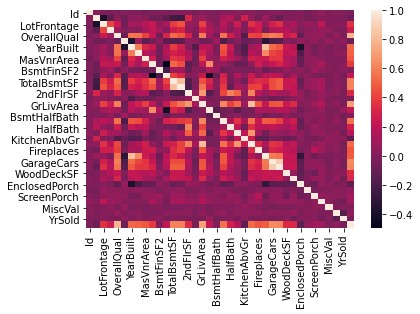

In [21]:
compare = train.corr()
g = sns.heatmap(train.corr())

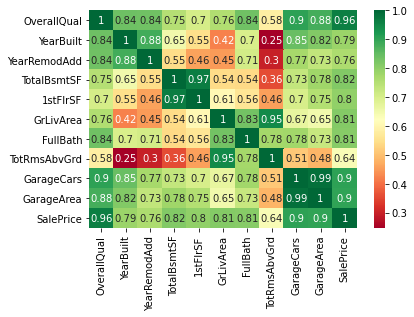

In [22]:
# most correlated features
top_corr_features = compare.index[abs(compare["SalePrice"])>0.5]
g = sns.heatmap(compare[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Below shows the sale price column on its own . 

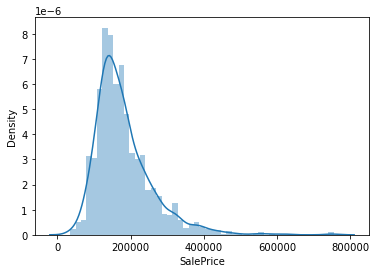

In [23]:
sns.distplot(train['SalePrice']);
#observation = deviates from normal distribution, skews positively,

In [24]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Checking for NAs

In [25]:
#Checking for missing data
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
MSZoning,0,4.0
LotFrontage,259,227.0
Alley,1369,1352.0
Utilities,0,2.0
Exterior1st,0,1.0
Exterior2nd,0,1.0
MasVnrType,8,16.0
MasVnrArea,8,15.0
BsmtQual,37,44.0
BsmtCond,37,45.0


Splitting to features and labels and deleting variables I don't need

In [26]:
# Spliting to features and lables and deleting variable I don't need
train_labels = train.pop('SalePrice')

features = pd.concat([train, test], keys=['train', 'test'])

# I decided to get rid of features that have more than half of missing information or do not correlate to SalePrice
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)


Filling NAs and converting features

In [27]:
# MSSubClass as str
features['MSSubClass'] = features['MSSubClass'].astype(str)

# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# Alley  NA in all. NA means no access
features['Alley'] = features['Alley'].fillna('NOACCESS')

# Converting OverallCond to str
features.OverallCond = features.OverallCond.astype(str)

# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')

# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenAbvGr to categorical
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)

# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# FireplaceQu  NA in all. NA means No Fireplace
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')

# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# Year and Month to categorical
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

Log transformation

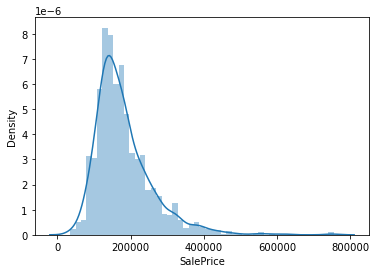

In [28]:
ax = sns.distplot(train_labels)

In [29]:
## Log transformation of labels
train_labels = np.log(train_labels)



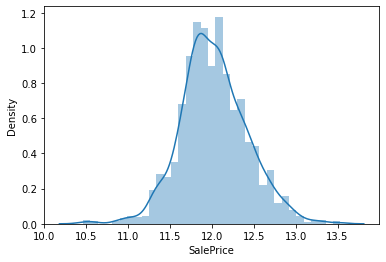

In [30]:
## Now it looks much better
ax = sns.distplot(train_labels)

Transformed the data in order to make it more interpretable.


Standardizing numeric data

In [31]:
## Standardizing numeric features
numeric_features = features.loc[:,['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()

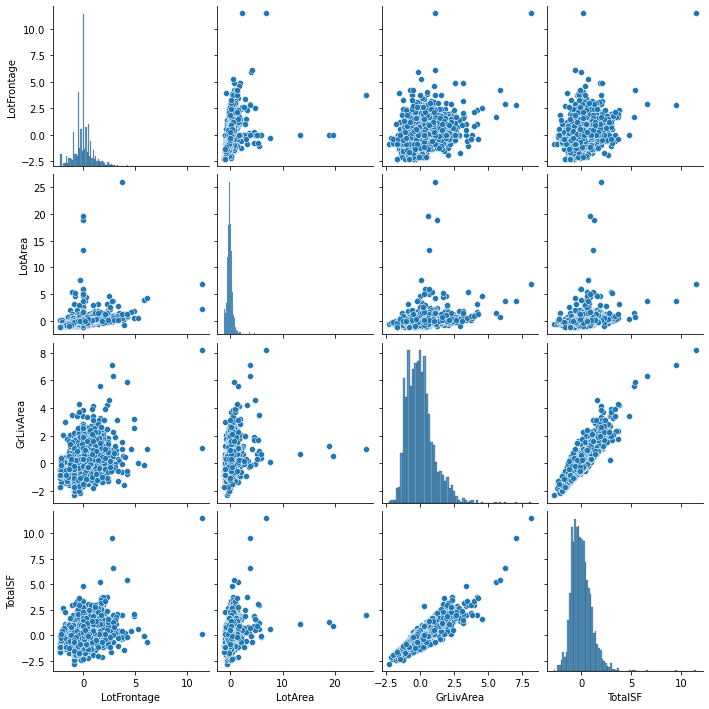

In [32]:


ax = sns.pairplot(numeric_features_standardized)



Converting categorical data to dummies

In [33]:
# Getting Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)

Obtaining standardized dataset

In [34]:
### Copying features
features_standardized = features.copy()

### Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)


Splitting train and test features

In [35]:
### Splitting features
train_features = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

### Splitting standardized features
train_features_st = features_standardized.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values


In [36]:
### Shuffling train sets
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)


In [37]:
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)

In [38]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train_st, y_train_st)
train_test(ENSTest, x_train_st, x_test_st, y_train_st, y_test_st)


ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10],
             l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000)
R2: 0.9026710177993915
RMSE: 0.11834117607868948
Test
R2: 0.8969305453847547
RMSE: 0.11028346070954063


In [39]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(ENSTest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.87 (+/- 0.12)


As a linear model, the accuracy is great but we can still definitely boost to get a better score. 

I'm using max_features='sqrt' to reduce overfitting of my model since we are using a lot of features and have many outliers.
I also use loss='huber' because it is more tolerant to outliers. We are using ensemble boosting methods to increase our final score. 

In [40]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GBest, x_train, x_test, y_train, y_test)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_features='sqrt',
                          min_samples_leaf=15, min_samples_split=10,
                          n_estimators=3000)
R2: 0.9620060045217614
RMSE: 0.07568099199432748
Test
R2: 0.9008980379712418
RMSE: 0.10828602858824624


In [41]:


# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(GBest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy: 0.90 (+/- 0.04)


My final ensemble model is an average of Gradient Boosting and Elastic Net predictions. But before that I retrained my models on all train data.

In [42]:
# Retraining models
GB_model = GBest.fit(train_features, train_labels)
ENST_model = ENSTest.fit(train_features_st, train_labels)

In [43]:
## Getting our SalePrice estimation
Final_labels = (np.exp(GB_model.predict(test_features)) + np.exp(ENST_model.predict(test_features_st))) / 2

I still need to fine tune this document and add more comments 